In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt  # PyWavelets library
from scipy import signal

# Load background data
print("Loading background data...")
background_df = pd.read_csv('background_data_decimated.csv')

print(f"Background data: {len(background_df):,} samples, {background_df['time_s'].iloc[-1]/60:.1f} min")
print(f"Sampling rate: 5000 Hz (after decimation)")

# Extract current signal
background_signal = background_df['Isd'].values
time = background_df['time_s'].values

print("\nWavelet Analysis Overview:")
print("- Mexican Hat (Ricker) wavelet decomposes signal into different scales")
print("- Identifies frequency components in the 1/f noise")
print("- Allows separation of baseline drift from high-frequency fluctuations")

Loading background data...
Background data: 4,727,369 samples, 15.8 min
Sampling rate: 5000 Hz (after decimation)

Wavelet Analysis Overview:
- Mexican Hat (Ricker) wavelet decomposes signal into different scales
- Identifies frequency components in the 1/f noise
- Allows separation of baseline drift from high-frequency fluctuations


In [7]:
def analyze_background_wavelet(signal, sampling_rate=5000, max_time=60):
    """
    Perform Mexican Hat wavelet analysis on background data
    
    Parameters:
    -----------
    signal : array
        Current measurements
    sampling_rate : int
        Hz (5000 for decimated data)
    max_time : float
        Only analyze first N seconds for speed
    """
    
    # Use subset for computational efficiency
    n_samples = int(max_time * sampling_rate)
    signal_subset = signal[:n_samples]
    time_subset = np.arange(len(signal_subset)) / sampling_rate
    
    print(f"\nAnalyzing first {max_time} seconds ({len(signal_subset):,} samples)...")
    
    # Define scales (corresponds to different frequencies)
    # Scales roughly correspond to periods: small scale = high freq, large scale = low freq
    scales = np.arange(1, 128)
    
    # Perform Continuous Wavelet Transform with Mexican Hat
    coefficients, frequencies = pywt.cwt(signal_subset, scales, 'mexh', 
                                         sampling_period=1/sampling_rate)
    
    print(f"✓ Wavelet transform complete")
    print(f"  Frequency range: {frequencies.min():.1f} Hz to {frequencies.max():.1f} Hz")
    print(f"  Number of scales: {len(scales)}")
    
    return coefficients, frequencies, time_subset, signal_subset

# Run wavelet analysis
coefficients, frequencies, time_subset, signal_subset = analyze_background_wavelet(
    background_signal, 
    sampling_rate=5000, 
    max_time=60  # First 60 seconds
)


Analyzing first 60 seconds (300,000 samples)...
✓ Wavelet transform complete
  Frequency range: 9.8 Hz to 1250.0 Hz
  Number of scales: 127


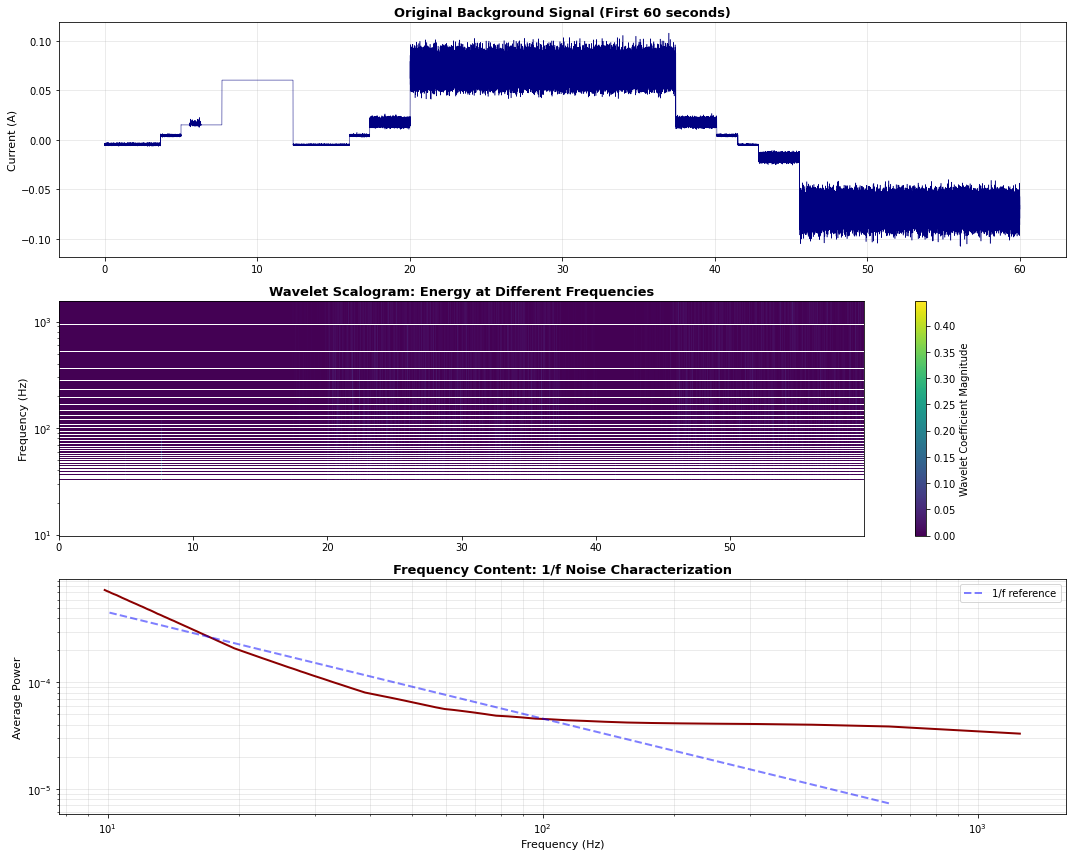

- Top: Raw current signal showing noise fluctuations
- Middle: Time-frequency map (darker = more energy at that frequency/time)
- Bottom: Frequency spectrum showing 1/f noise behavior


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Original signal
axes[0].plot(time_subset, signal_subset, linewidth=0.5, color='navy')
axes[0].set_ylabel('Current (A)', fontsize=11)
axes[0].set_title('Original Background Signal (First 60 seconds)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Wavelet scalogram (time-frequency representation)
im = axes[1].pcolormesh(time_subset, frequencies, np.abs(coefficients), 
                        cmap='viridis', shading='auto')
axes[1].set_ylabel('Frequency (Hz)', fontsize=11)
axes[1].set_title('Wavelet Scalogram: Energy at Different Frequencies', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
plt.colorbar(im, ax=axes[1], label='Wavelet Coefficient Magnitude')

# Power spectrum at different frequencies
power_spectrum = np.mean(np.abs(coefficients)**2, axis=1)
axes[2].loglog(frequencies, power_spectrum, linewidth=2, color='darkred')
axes[2].set_xlabel('Frequency (Hz)', fontsize=11)
axes[2].set_ylabel('Average Power', fontsize=11)
axes[2].set_title('Frequency Content: 1/f Noise Characterization', fontsize=13, fontweight='bold')
axes[2].grid(True, which='both', alpha=0.3)

# Add 1/f reference line
freq_range = frequencies[(frequencies > 10) & (frequencies < 1000)]
reference = power_spectrum[np.argmin(np.abs(frequencies - 100))] * (freq_range / 100) ** (-1)
axes[2].loglog(freq_range, reference, 'b--', linewidth=2, alpha=0.5, label='1/f reference')
axes[2].legend()

plt.tight_layout()
plt.savefig('wavelet_analysis_background.png', dpi=150, bbox_inches='tight')
plt.show()

print("- Top: Raw current signal showing noise fluctuations")
print("- Middle: Time-frequency map (darker = more energy at that frequency/time)")
print("- Bottom: Frequency spectrum showing 1/f noise behavior")

In [9]:
def denoise_with_wavelet(signal, wavelet='mexh', threshold_factor=0.5):
    """
    Denoise signal using wavelet thresholding
    
    Parameters:
    -----------
    signal : array
        Input signal
    wavelet : str
        Wavelet type (mexh = Mexican Hat)
    threshold_factor : float
        Threshold multiplier (higher = more aggressive denoising)
    """
    
    # Use discrete wavelet transform for denoising
    # Note: Mexican Hat is continuous; use db4 (Daubechies) for discrete
    wavelet_type = 'db4'  # Good general-purpose wavelet
    
    # Perform multilevel wavelet decomposition
    coeffs = pywt.wavedec(signal, wavelet_type, level=5)
    
    # Calculate threshold based on median absolute deviation
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * threshold_factor * np.sqrt(2 * np.log(len(signal)))
    
    print(f"\nWavelet Denoising:")
    print(f"  Wavelet: {wavelet_type}")
    print(f"  Decomposition levels: 5")
    print(f"  Threshold: {threshold:.6e}")
    
    # Apply soft thresholding to detail coefficients
    coeffs_thresh = [coeffs[0]]  # Keep approximation coefficients
    for i in range(1, len(coeffs)):
        coeffs_thresh.append(pywt.threshold(coeffs[i], threshold, mode='soft'))
    
    # Reconstruct signal
    denoised = pywt.waverec(coeffs_thresh, wavelet_type)
    
    # Handle length mismatch from wavelet transform
    if len(denoised) > len(signal):
        denoised = denoised[:len(signal)]
    elif len(denoised) < len(signal):
        denoised = np.pad(denoised, (0, len(signal) - len(denoised)), mode='edge')
    
    # Calculate noise reduction
    noise = signal - denoised
    snr_improvement = 10 * np.log10(np.var(signal) / np.var(noise))
    
    print(f"  SNR improvement: {snr_improvement:.2f} dB")
    print(f"  Noise std: {np.std(noise):.6e} A")
    
    return denoised, noise

# Denoise the full background signal
background_denoised, background_noise = denoise_with_wavelet(
    background_signal,
    threshold_factor=0.5
)


Wavelet Denoising:
  Wavelet: db4
  Decomposition levels: 5
  Threshold: 2.289296e-02
  SNR improvement: 9.75 dB
  Noise std: 8.293408e-03 A


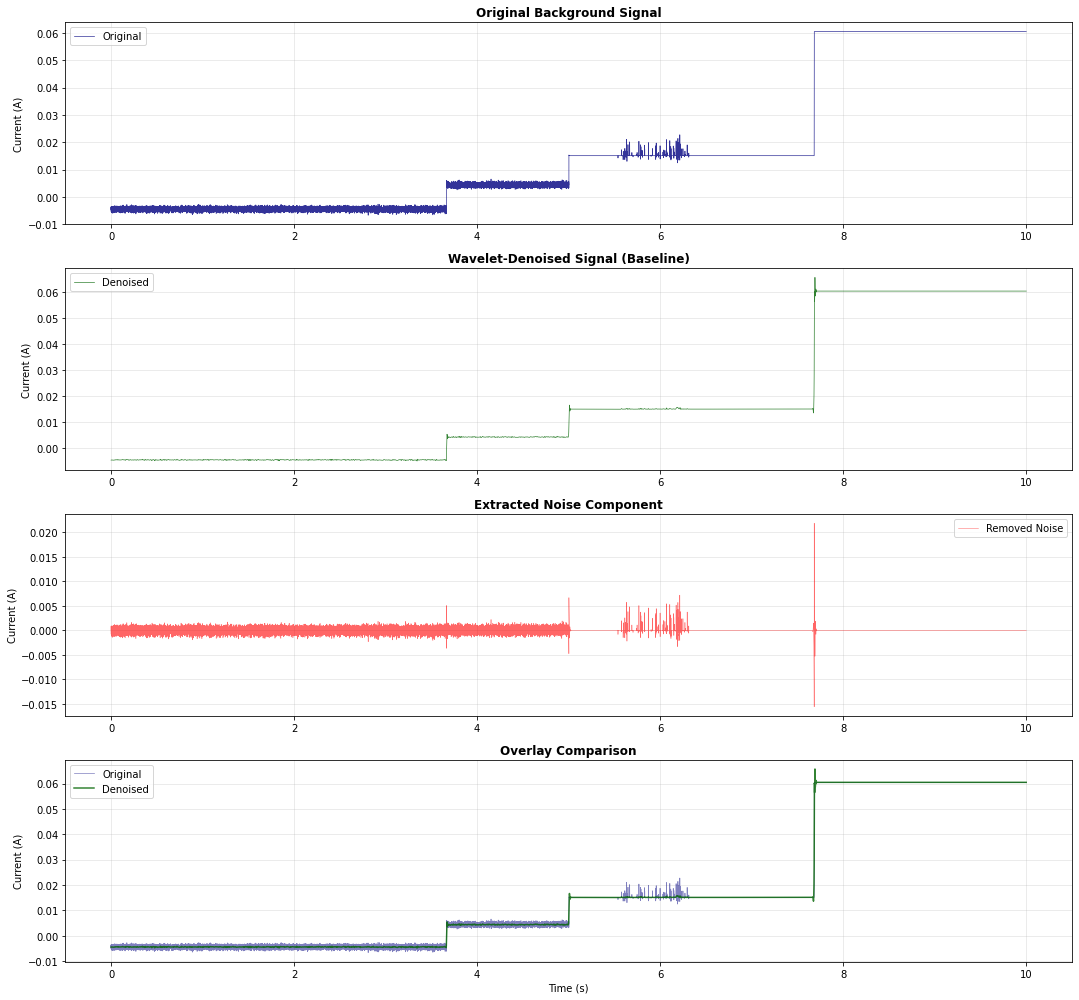

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(15, 14))

# Use first 10 seconds for visualization
vis_samples = 50000  # 10 seconds at 5 kHz
vis_time = time[:vis_samples]

# Original signal
axes[0].plot(vis_time, background_signal[:vis_samples], 
             linewidth=0.7, color='navy', alpha=0.8, label='Original')
axes[0].set_ylabel('Current (A)')
axes[0].set_title('Original Background Signal', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Denoised signal
axes[1].plot(vis_time, background_denoised[:vis_samples], 
             linewidth=0.7, color='darkgreen', alpha=0.8, label='Denoised')
axes[1].set_ylabel('Current (A)')
axes[1].set_title('Wavelet-Denoised Signal (Baseline)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Extracted noise
axes[2].plot(vis_time, background_noise[:vis_samples], 
             linewidth=0.5, color='red', alpha=0.6, label='Removed Noise')
axes[2].set_ylabel('Current (A)')
axes[2].set_title('Extracted Noise Component', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Comparison: original vs denoised
axes[3].plot(vis_time, background_signal[:vis_samples], 
             linewidth=0.7, color='navy', alpha=0.5, label='Original')
axes[3].plot(vis_time, background_denoised[:vis_samples], 
             linewidth=1.5, color='darkgreen', alpha=0.8, label='Denoised')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Current (A)')
axes[3].set_title('Overlay Comparison', fontsize=12, fontweight='bold')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('wavelet_denoising_results.png', dpi=150, bbox_inches='tight')
plt.show()


📊 Background Noise Characterization:
  Mean: 2.858706e-10 A (should be ~0)
  Std Dev: 8.293408e-03 A
  RMS: 8.293408e-03 A

✓ Saved: background_wavelet_model.csv


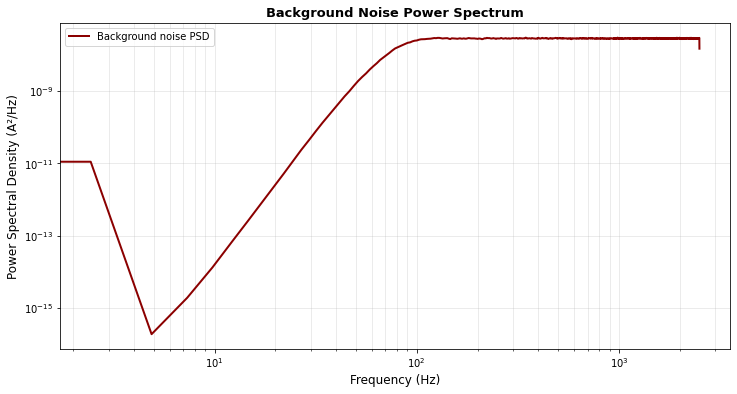

In [11]:
# Calculate noise statistics for subtraction
background_noise_mean = np.mean(background_noise)
background_noise_std = np.std(background_noise)

# Power spectral density of noise
freq_noise, psd_noise = signal.welch(background_noise, fs=5000, nperseg=2048)

print("\n📊 Background Noise Characterization:")
print(f"  Mean: {background_noise_mean:.6e} A (should be ~0)")
print(f"  Std Dev: {background_noise_std:.6e} A")
print(f"  RMS: {np.sqrt(np.mean(background_noise**2)):.6e} A")

# Save denoised baseline and noise model
background_model = pd.DataFrame({
    'time_s': time,
    'baseline': background_denoised,
    'noise': background_noise
})

background_model.to_csv('background_wavelet_model.csv', index=False)
print(f"\n✓ Saved: background_wavelet_model.csv")

# Plot noise PSD
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(freq_noise, psd_noise, linewidth=2, color='darkred', label='Background noise PSD')
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (A²/Hz)', fontsize=12)
ax.set_title('Background Noise Power Spectrum', fontsize=13, fontweight='bold')
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.savefig('background_noise_psd.png', dpi=150, bbox_inches='tight')
plt.show()


Background Subtraction:
  Baseline mean: 6.460874e-02 A
  EDC original mean: 7.032379e-02 A
  EDC corrected mean: 5.715049e-03 A


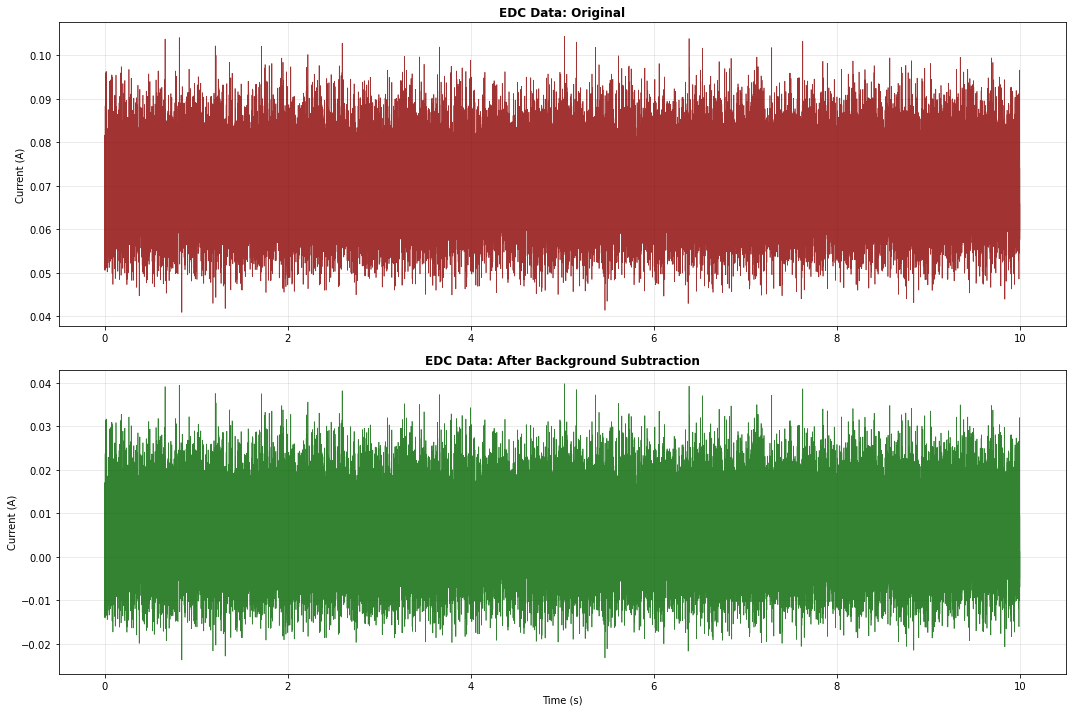


✓ Saved: edc_corrected.csv


In [12]:
def subtract_background_from_edc(edc_signal, background_baseline):
    """
    Subtract baseline trend from EDC data
    
    Note: Background and EDC are different lengths, so we subtract 
    the mean baseline level, not point-by-point
    """
    
    # Method 1: Subtract mean baseline (simple)
    baseline_mean = np.mean(background_baseline)
    edc_corrected_simple = edc_signal - baseline_mean
    
    # Method 2: Subtract baseline + noise statistics (advanced)
    # This would involve matching noise characteristics
    
    print(f"\nBackground Subtraction:")
    print(f"  Baseline mean: {baseline_mean:.6e} A")
    print(f"  EDC original mean: {np.mean(edc_signal):.6e} A")
    print(f"  EDC corrected mean: {np.mean(edc_corrected_simple):.6e} A")
    
    return edc_corrected_simple

# Load EDC data
edc_df = pd.read_csv('edc_full_data_decimated.csv')
edc_signal = edc_df['Isd'].values

# Perform background subtraction
edc_corrected = subtract_background_from_edc(edc_signal, background_denoised)

# Visualize correction
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

vis_samples = 50000
edc_time = edc_df['time_s'].values[:vis_samples]

axes[0].plot(edc_time, edc_signal[:vis_samples], 
             linewidth=0.7, color='darkred', alpha=0.8)
axes[0].set_ylabel('Current (A)')
axes[0].set_title('EDC Data: Original', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(edc_time, edc_corrected[:vis_samples], 
             linewidth=0.7, color='darkgreen', alpha=0.8)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')
axes[1].set_title('EDC Data: After Background Subtraction', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('edc_background_subtraction.png', dpi=150, bbox_inches='tight')
plt.show()

# Save corrected EDC data
edc_corrected_df = pd.DataFrame({
    'time_s': edc_df['time_s'].values,
    'Isd_corrected': edc_corrected,
    'Isd_original': edc_signal
})

edc_corrected_df.to_csv('edc_corrected.csv', index=False)
print(f"\n✓ Saved: edc_corrected.csv")